<a href="https://colab.research.google.com/github/kubyllka/BERTopic-News-Analysis/blob/main/News_topic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling Task
Existing algorithms:
*   BERTopic
*   LSA (Latent Semantic Analysis)
*   LDA (Latent Dirichlet Allocation)
*   NMF (Non-negative Matrix Factorization)
*   KeyBERT
*   Top2Vec

## Best options
* BERTopic concatenates all documents within the same cluster (topic) and applies a modified TF-IDF. In brief, it replaces documents with clusters in the original TF-IDF formula. Then, it uses the first most important words for each cluster as topic representation.

* Top2Vec, instead, manufactures a representation with the words closest to the cluster’s centroid. In particular, for each dense area obtained through HDBSCAN, it calculates the centroid of document vectors in original dimension, then selects the most proximal word vectors.

**BERTopic outperforms traditional models by combining transformer-based embeddings with clustering and class-based TF-IDF. This results in more coherent, multilingual, and context-aware topics, especially effective for short, real-world texts like news headlines.**

Used examples:
*   [What is Topic Modeling? An Introduction With Examples](https://www.datacamp.com/tutorial/what-is-topic-modeling)
* [Topic modeling algorithms | Medium](https://medium.com/@m.nath/topic-modeling-algorithms-b7f97cec6005)
* [BERTopic | Best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#training)



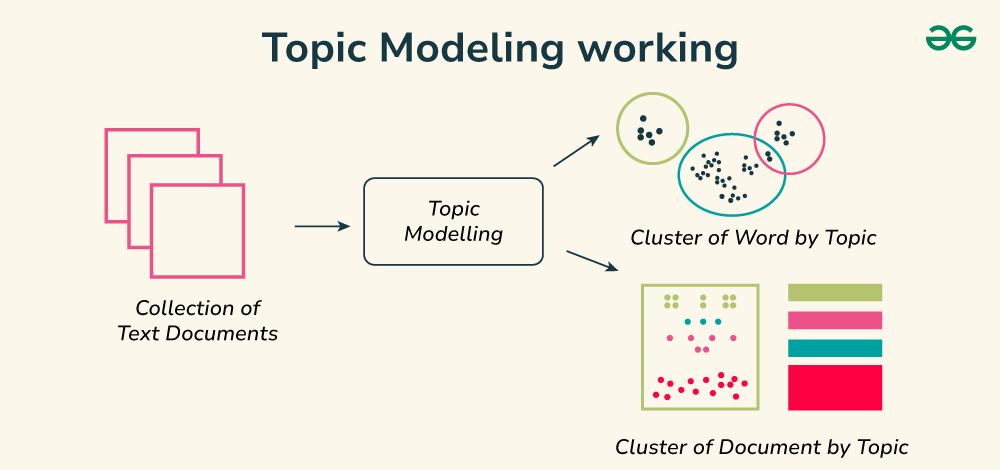

In [1]:
!pip install bertopic sentence-transformers umap-learn hdbscan scikit-learn matplotlib seaborn pandas openpyxlq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [31]:
!pip install spacy

In [32]:
!python -m spacy download uk_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 4.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from google.colab import userdata
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import os

# Data Analysis

In [3]:
# Downloading the data
ukr_news = pd.read_excel("/content/drive/MyDrive/Data Science Testing/Data for Test Task_ML Engineer_Data Science UA (1) (1).xlsx", sheet_name="Україна")

In [4]:
world_news = pd.read_excel("/content/drive/MyDrive/Data Science Testing/Data for Test Task_ML Engineer_Data Science UA (1) (1).xlsx", sheet_name="Міжнародні")

In [5]:
ukr_news.head()

,Дата,Джерело,Заголовок,Опис,Посилання,Автор,Популярність джерела,Мова,Країна
0,2025-02-12 09:28:50,сайт тернополя 0352.ua,"""200 тисяч – одразу, а через рік – виїзд за ко...",Про зниження мобілізаційного віку розмови трив...,https://www.0352.ua/news/3901613/200-tisac-odr...,Дмитро Бондаренко,116319,uk,UA
1,2025-02-12 19:39:16,Gazeta.ua,"""30 000 на місяць"": Зеленський пояснив, наскіл...",Найбільша мобілізація в Україні відбулася у 20...,https://gazeta.ua/articles/life/_30-000-na-mis...,Максимчук Леонід,19872,uk,UA
2,2025-02-09 18:20:00,сайт тернополя 0352.ua,"""34 000 грн штрафу та позбавлення прав"": в Укр...",З'явилося попереджання для українців,https://www.0352.ua/news/3900464/34-000-grn-st...,Георгій Шевчук,116319,uk,UA
3,2025-02-11 14:30:00,Patriot of Ukraine,"""90% успіху Росії в Криму в 2014-му році - це ...",Головний сержант 126 ОБр ТрО 30-го корпусу мор...,https://patrioty.org.ua/politic/90-uspikhu-ros...,NaN,234013,uk,UA
4,2025-02-11 16:11:00,24 Канал,"""Є приклади успішних"": в ОСУВ ""Хортиця"" відпов...",ЗСУ проводять успішні контратаки на Покровсько...,https://24tv.ua/kontrataki-zsu-bilya-pokrovska...,Дмитро Усик,14630,uk,UA


In [6]:
ukr_news['Мова'].unique()

array(['uk'], dtype=object)

In [7]:
ukr_news['Країна'].unique()

array(['UA'], dtype=object)

In [8]:
world_news.head()

,Дата,Джерело,Заголовок,Опис,Посилання,Автор,Популярність джерела,Мова,Країна
0,2025-02-13 13:07:18,Reuters,"""50% battle-ready"": Germany misses military ta...",The German army's battle-readiness is less tha...,https://www.reuters.com/world/europe/50-battle...,Sabine Siebold,101,en,GB
1,2025-02-13 13:09:45,The Straits Times,"""50% battle-ready"": Germany misses military ta...",BERLIN - The German army's battle-readiness is...,https://www.straitstimes.com/world/europe/50-b...,NaN,1187,en,SG
2,2025-02-13 13:06:39,AOL,"""50% battle-ready"": Germany misses military ta...",The German army's battle-readiness is less tha...,https://www.aol.com/news/50-battle-ready-germa...,Sabine Siebold,295,en,US
3,2025-02-15 17:09:24,NDTV,"""Armed Forces Of Europe Must Be Created"": Zele...",Ukrainian President Volodymyr Zelensky called ...,https://www.ndtv.com/world-news/armed-forces-o...,Agence France-Presse,841,en,IN
4,2025-02-09 11:21:49,NDTV,"""Can't Confirm Or Deny"": Kremlin On Reports Of...",The Kremlin on Sunday declined to confirm or d...,https://www.ndtv.com/world-news/cant-confirm-o...,Agence France-Presse,841,en,IN


In [9]:
world_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Дата                  9346 non-null   object
 1   Джерело               9339 non-null   object
 2   Заголовок             9346 non-null   object
 3   Опис                  7614 non-null   object
 4   Посилання             9346 non-null   object
 5   Автор                 8170 non-null   object
 6   Популярність джерела  9346 non-null   int64 
 7   Мова                  9346 non-null   object
 8   Країна                9346 non-null   object
dtypes: int64(1), object(8)
memory usage: 657.3+ KB


In [10]:
world_news['Країна'].unique()

array(['GB', 'SG', 'US', 'IN', 'FR', 'DE', 'CA', 'KR', 'CN', 'IL', 'RO',
       'AU', 'unknown', 'HK', 'AF', 'BE', 'QA', 'IE', 'ES', 'JP', 'CH',
       'NZ', 'NL', 'SC', 'BR'], dtype=object)

In [11]:
world_news['Мова'].unique()

array(['en'], dtype=object)

In [12]:
ukr_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14577 entries, 0 to 14576
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Дата                  14577 non-null  object
 1   Джерело               14139 non-null  object
 2   Заголовок             14577 non-null  object
 3   Опис                  14573 non-null  object
 4   Посилання             14577 non-null  object
 5   Автор                 12802 non-null  object
 6   Популярність джерела  14577 non-null  int64 
 7   Мова                  14577 non-null  object
 8   Країна                14577 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


# Data preprocessing

## Relevant columns

In [13]:
columns_to_keep = ["Дата", "Джерело", "Заголовок", "Опис", "Популярність джерела"]
ua_df = ukr_news[columns_to_keep].copy()
intl_df = world_news[columns_to_keep].copy()

## Removing non-informative rows

In [15]:
def remove_exact_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes exact duplicates based on the combination of 'Заголовок' (Headline) and 'Опис' (Description).

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with exact duplicates removed.
    """
    initial_rows = len(df)

    # Create a combined text column for duplicate detection
    # Fill NaN values with empty strings to prevent errors during concatenation
    df["combined_text"] = df["Заголовок"].fillna("") + " " + df["Опис"].fillna("")

    # Drop duplicates based on the 'combined_text' column
    df_cleaned = df.drop_duplicates(subset=["combined_text"]).copy()

    df_cleaned = df_cleaned.drop(columns=["combined_text"])

    removed_rows = initial_rows - len(df_cleaned)
    print(f"Removed {removed_rows} exact duplicates.")

    return df_cleaned

In [16]:
# Removing exact duplicates in both datasets
ua_df = remove_exact_duplicates(ua_df)
intl_df = remove_exact_duplicates(intl_df)

Removed 198 exact duplicates.
Removed 1122 exact duplicates.


In [17]:
def clean_text_for_length(text: str) -> str:
    """
    Cleans text by converting to lowercase, removing URLs, and normalizing whitespace.
    Used internally for length-based filtering.

    Args:
        text (str): Input text.

    Returns:
        str: Cleaned text.
    """
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Remove URLs if present
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Normalize whitespace (replace multiple spaces with a single one and strip leading/trailing)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_short_and_uninformative(df: pd.DataFrame, min_chars: int = 100, min_words: int = 10) -> pd.DataFrame:
    """
    Removes entries where the combined headline and description text is too short or uninformative
    after basic cleaning.

    Args:
        df (pd.DataFrame): The input DataFrame.
        min_chars (int): Minimum number of characters required for the combined text.
        min_words (int): Minimum number of words required for the combined text.

    Returns:
        pd.DataFrame: A new DataFrame with short/uninformative entries removed.
    """
    initial_rows = len(df)

    # Create a cleaned combined text column for length analysis
    df["cleaned_combined_text_for_length"] = df.apply(
        lambda row: clean_text_for_length(row["Заголовок"]) + " " + clean_text_for_length(row["Опис"]), axis=1
    )

    # Filter out entries where the text is too short
    df_filtered = df[
        (df["cleaned_combined_text_for_length"].str.len() >= min_chars) &
        (df["cleaned_combined_text_for_length"].apply(lambda x: len(x.split())) >= min_words)
    ].copy()

    # Remove the temporary cleaned text column
    df_filtered = df_filtered.drop(columns=["cleaned_combined_text_for_length"])

    removed_rows = initial_rows - len(df_filtered)
    print(f"Removed {removed_rows} short or uninformative entries (min_chars={min_chars}, min_words={min_words}).")
    return df_filtered

In [18]:
ua_df = remove_short_and_uninformative(ua_df, min_chars=100, min_words=10)
intl_df = remove_short_and_uninformative(intl_df, min_chars=100, min_words=10)

Removed 634 short or uninformative entries (min_chars=100, min_words=10).
Removed 1761 short or uninformative entries (min_chars=100, min_words=10).


## Visualization of source popularity distribution

In [19]:
def plot_source_popularity_distribution(df, col="Популярність джерела", bins=50, show_kde=True, title="Source Popularity Distribution"):
    """
    Plot a histogram of values in the specified numerical column (typically 'Source Popularity').

    Parameters:
    - df: pandas DataFrame
    - col: name of the numerical column to visualize (default = 'Популярність джерела')
    - bins: number of histogram bins (default = 50)
    - show_kde: whether to show the KDE (density curve) overlay (default = True)
    - title: title of the plot (default = 'Source Popularity Distribution')
    """
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], bins=bins, kde=show_kde, color="steelblue", edgecolor="black")
    plt.title(title, fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

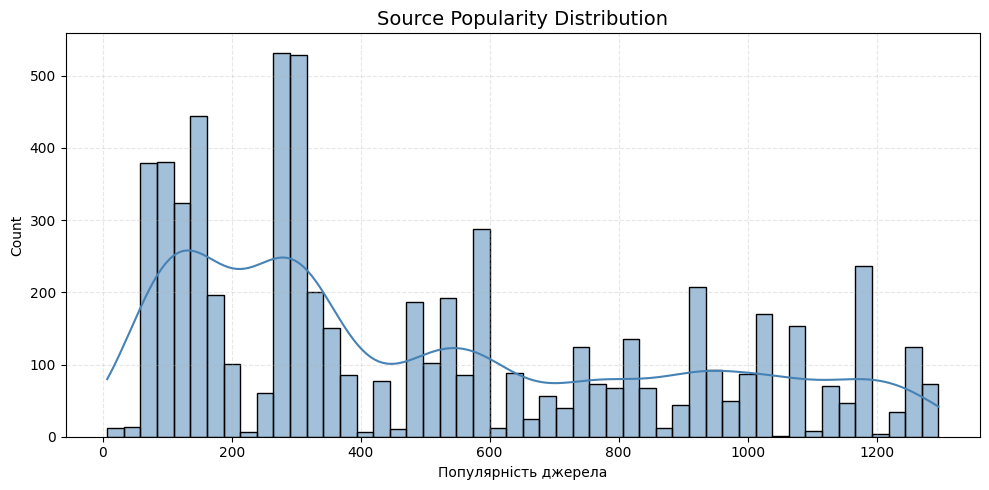

'\n"a more even distribution than in Ukrainian news. Although there is a peak around 200-300, it\'s not as extreme as the \'peak near zero\' in ua_df. \nThe popularity values here are much lower (maximum around 1300), and overall, there isn\'t such \'junk\' content at very low values, as there is for Ukrainian news."\n'

In [20]:
plot_source_popularity_distribution(intl_df)
"""
"a more even distribution than in Ukrainian news. Although there is a peak around 200-300, it's not as extreme as the 'peak near zero' in ua_df.
The popularity values here are much lower (maximum around 1300), and overall, there isn't such 'junk' content at very low values, as there is for Ukrainian news."
"""

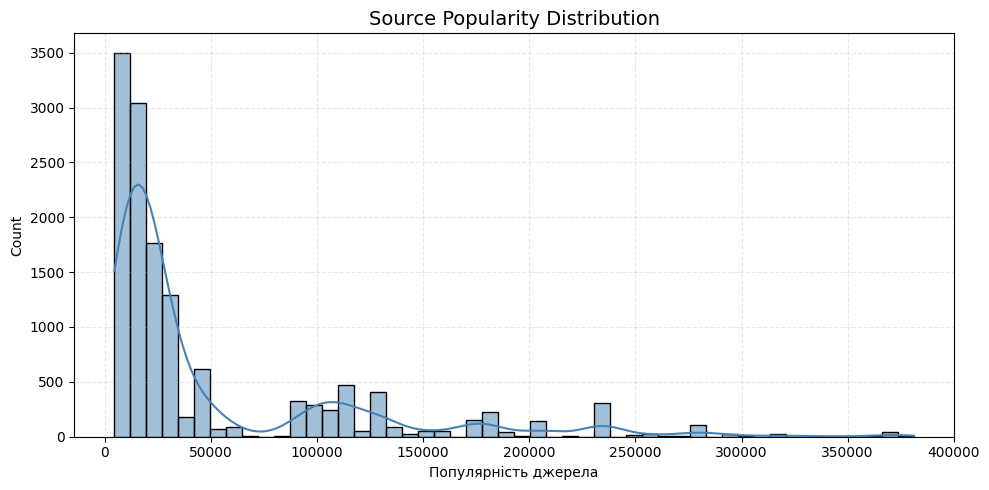

"\nWe observe a very strong peak near zero, indicating a huge number of sources with low popularity.\nHere, 'bottom-up' cleaning (from low percentiles) is extremely important for removing noise and focusing on more relevant data.\n The 'long tail' on the right also indicates the presence of highly popular sources, and the decision to cut them off 'from the top' remains relevant to prevent dominance.\n"

In [21]:
plot_source_popularity_distribution(ua_df)
"""
We observe a very strong peak near zero, indicating a huge number of sources with low popularity.
Here, 'bottom-up' cleaning (from low percentiles) is extremely important for removing noise and focusing on more relevant data.
 The 'long tail' on the right also indicates the presence of highly popular sources, and the decision to cut them off 'from the top' remains relevant to prevent dominance.
"""

## Data filtering by source popularity

In [23]:
def filter_by_source_popularity(df: pd.DataFrame, col: str = "Популярність джерела", lower_quantile: float = 0.20, upper_quantile: float = 0.95) -> pd.DataFrame:
    """
    Filters the DataFrame based on the popularity of the source, removing outliers.

    Args:
        df (pd.DataFrame): The input DataFrame.
        col (str): Name of the popularity column.
        lower_quantile (float): The lower percentile threshold (e.g., 0.20 to keep data above 20th percentile).
        upper_quantile (float): The upper percentile threshold (e.g., 0.95 to keep data below 95th percentile).

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    initial_rows = len(df)

    # Describe the popularity column to get statistical overview
    print("\nSource Popularity Statistics:")
    print(df[col].describe())

    # Calculate thresholds based on quantiles
    low_thresh = df[col].quantile(lower_quantile)
    high_thresh = df[col].quantile(upper_quantile)

    print(f"\nFiltering '{col}' based on quantiles:")
    print(f"  Lower threshold ({lower_quantile*100:.0f}th percentile): {low_thresh:.2f}")
    print(f"  Upper threshold ({upper_quantile*100:.0f}th percentile): {high_thresh:.2f}")

    # Apply the filter
    df_filtered = df[
        (df[col] >= low_thresh) &
        (df[col] <= high_thresh)
    ].copy()

    removed_rows = initial_rows - len(df_filtered)
    print(f"Removed {removed_rows} entries outside the popularity range.")
    print(f"Remaining entries after popularity filtering: {len(df_filtered)}")
    return df_filtered

In [24]:
# Filtering sources: removing the least (bottom 20%) and most (top 5%) popular to reduce noise and prevent dominance.
ua_df_filtered = filter_by_source_popularity(ua_df, lower_quantile=0.20, upper_quantile=0.95)


Source Popularity Statistics:
count     13745.000000
mean      51082.476682
std       65902.605954
min        4471.000000
25%       11945.000000
50%       19872.000000
75%       48467.000000
max      381277.000000
Name: Популярність джерела, dtype: float64

Filtering 'Популярність джерела' based on quantiles:
  Lower threshold (20th percentile): 11945.00
  Upper threshold (95th percentile): 207414.00
Removed 3323 entries outside the popularity range.
Remaining entries after popularity filtering: 10422


In [25]:
# Filtering sources: removing the least (bottom 1%) and most (top 5%) popular to reduce noise and prevent dominance.
intl_df_filtered = filter_by_source_popularity(intl_df, lower_quantile=0.01, upper_quantile=0.95)


Source Popularity Statistics:
count    6463.000000
mean      501.422714
std       367.502234
min         7.000000
25%       182.000000
50%       356.000000
75%       812.000000
max      1296.000000
Name: Популярність джерела, dtype: float64

Filtering 'Популярність джерела' based on quantiles:
  Lower threshold (1th percentile): 62.00
  Upper threshold (95th percentile): 1187.00
Removed 276 entries outside the popularity range.
Remaining entries after popularity filtering: 6187


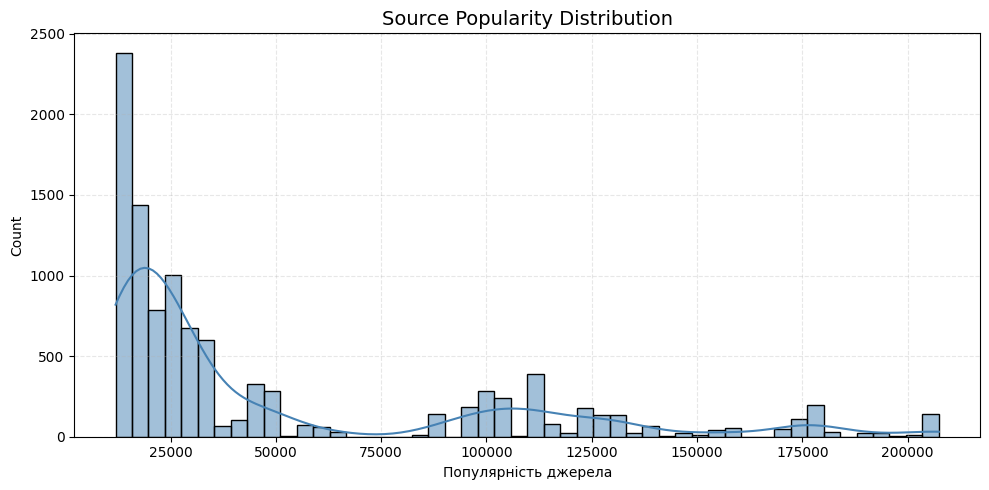

In [26]:
plot_source_popularity_distribution(ua_df_filtered)

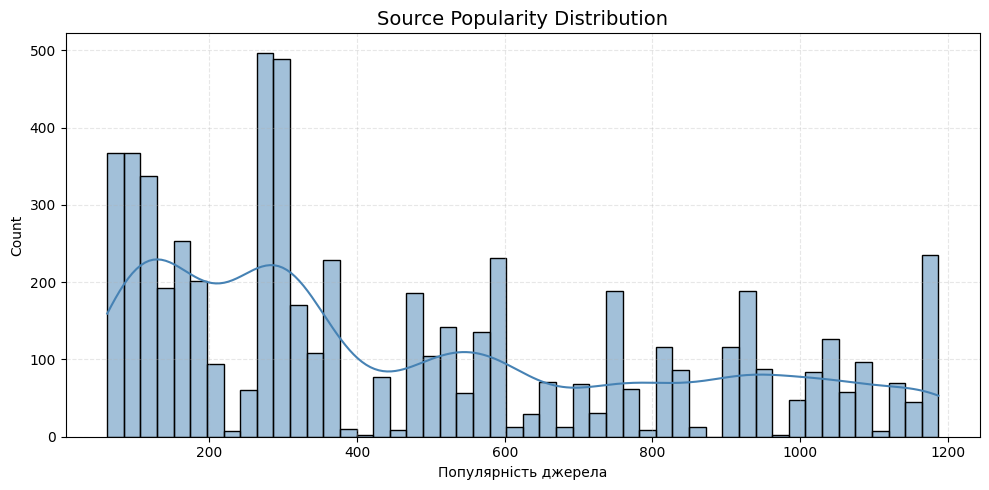

In [27]:
plot_source_popularity_distribution(intl_df_filtered)

# Text cleaning

In [77]:
def clean_text_for_topic_modeling(text: str) -> str:
    """
    Applies basic text preprocessing suitable for BERT-based models:
    - Converts to lowercase.
    - Removes punctuation (keeping only letters, numbers, and spaces).
    - Removes digits if they are not considered informative for topic modeling.
    - Normalizes whitespace.

    Args:
        text (str): Input text from 'Заголовок' or 'Опис'.

    Returns:
        str: Cleaned text.
    """
    if pd.isna(text):
        return ""

    text = str(text) # Ensure text is string

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove punctuation and special characters (keep letters, numbers, and spaces)
    # Keeping numbers here, as they might be part of specific events/products
    text = re.sub(r'[^a-zA-Zа-яА-ЯіІїЇєЄґҐ\d\s]', '', text)

    # 3. Normalize whitespace (replace multiple spaces with a single one and strip leading/trailing)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def prepare_text_and_metadata_for_bertopic(df: pd.DataFrame, date_col: str = 'Дата') -> pd.DataFrame:
    """
    Prepares the DataFrame for BERTTopic by:
    - Combining 'Заголовок' (Headline) and 'Опис' (Description) into a 'document' column.
    - Applying basic text cleaning to the 'document' column.
    - Converting the date column to datetime objects.
    - Removing any empty documents or rows with invalid dates after processing.

    Args:
        df (pd.DataFrame): The input DataFrame (already filtered by popularity/duplicates).
        date_col (str): The name of the date column.

    Returns:
        pd.DataFrame: DataFrame with 'document' and processed 'Дата' columns, ready for BERTTopic.
    """
    initial_rows = len(df)

    # Create the combined text column
    df['document'] = df['Заголовок'].fillna('') + ' ' + df['Опис'].fillna('')

    # Apply text cleaning to the 'document' column
    print("Applying text cleaning to 'document' column...")
    df['document'] = df['document'].apply(clean_text_for_topic_modeling)

    # Remove any documents that became empty after cleaning
    df = df[df['document'].str.len() > 0].copy()
    if len(df) < initial_rows:
        print(f"Removed {initial_rows - len(df)} documents that became empty after cleaning.")
        initial_rows = len(df) # Update initial_rows for date check

    # Convert date column to datetime
    if date_col in df.columns:
        print(f"Converting '{date_col}' column to datetime...")
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

        # Remove rows where date conversion failed
        df.dropna(subset=[date_col], inplace=True)
        if len(df) < initial_rows:
            print(f"Removed {initial_rows - len(df)} rows due to invalid date values in '{date_col}'.")
    else:
        print(f"Warning: Date column '{date_col}' not found in DataFrame. Cannot prepare timestamps.")

    return df

In [78]:
ukr_df_final = prepare_text_and_metadata_for_bertopic(ua_df_filtered.copy())

Applying text cleaning to 'document' column...
Converting 'Дата' column to datetime...


In [79]:
ukr_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10422 entries, 0 to 14576
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Дата                  10422 non-null  datetime64[ns]
 1   Джерело               9995 non-null   object        
 2   Заголовок             10422 non-null  object        
 3   Опис                  10422 non-null  object        
 4   Популярність джерела  10422 non-null  int64         
 5   document              10422 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 570.0+ KB


In [30]:
intl_df_final = prepare_text_and_metadata_for_bertopic(intl_df_filtered.copy())

Applying text cleaning to 'document' column...
Converting 'Дата' column to datetime...


# BERTopic using

### Need to delete stop words for english and ukrainian beacause following results

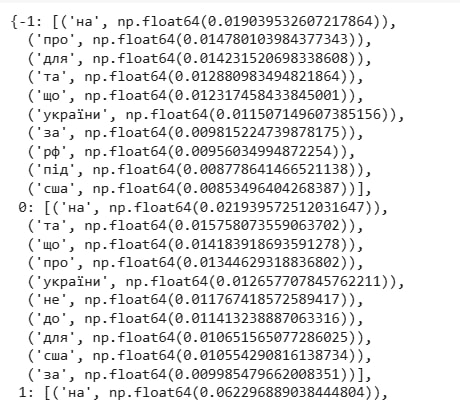

In [33]:
ukrainian_stop_words = [
    "а", "або", "але", "без", "біля", "більш", "був", "була", "були", "було", "бути", "вам", "вас", "весь", "він",
    "від", "вона", "вони", "все", "всі", "вся", "геть", "де", "для", "до", "ж", "же", "за", "звичайно", "зовсім",
    "і", "із", "им", "інші", "інший", "їй", "їм", "їх", "й", "коли", "кому", "котра", "котрий", "котре", "котрі",
    "крім", "куди", "лише", "може", "можна", "ми", "на", "навіть", "над", "наприклад", "нас", "не", "нею", "нижче",
    "них", "ні", "ніж", "нього", "о", "один", "одна", "одне", "одні", "от", "ось", "під", "після", "по", "поки",
    "поруч", "потім", "при", "про", "проте", "раз", "разом", "та", "таке", "такий", "також", "там", "те", "тепер",
    "тим", "тільки", "то", "той", "тому", "тут", "у", "хоча", "хто", "цей", "ця", "це", "ці", "час", "часто",
    "чого", "через", "чи", "чий", "чия", "чиє", "чиї", "що", "щоб", "як", "яка", "який", "яке", "які", "якраз",
    "якщо", "ясно", "я", "їй", "їм", "їх", "тощо", "таке", "таких", "це", "це", "ці", "цим", "цих", "яка", "які",
    "що", "на", "про", "для", "та", "не", "до", "за",
]

In [35]:
# Prompts for OpenAI representation models

prompt_urk = """
Завдання: Сформулювати заголовок для новинної теми.

Надані матеріали для аналізу:
- Документи, що входять до теми:
[DOCUMENTS]
- Ключові слова, що описують тему:
[KEYWORDS]

Спираючись на вищезазначену інформацію, створіть коротку, але максимально змістовну та описову назву або інформаційний привід для цієї новинної теми. Заголовок має бути схожим на реальний новинний заголовок і не повинен перевищувати 8 слів.

Формат відповіді:
topic: <ваш заголовок теми>
"""

prompt_eng = """
Task: Formulate a headline for a news topic.

Provided materials for analysis:
- Documents included in the topic:
[DOCUMENTS]
- Keywords describing the topic:
[KEYWORDS]

Based on the information above, create a short but highly meaningful and descriptive title or news event brief for this news topic. The headline should resemble a real news headline and should not exceed 8 words.

Response format:
topic: <your topic headline>
"""

## [For this part I use Best Practicies from author of BERTopic ](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#topic-document-distribution)

In [36]:
def get_representation_model(current_language: str, openai_api_key: str = None) -> dict:
    """
    Initializes and returns a dictionary of BERTopic representation models
    according to the specified language.

    Args:
        current_language (str): The language for model setup ('uk' for Ukrainian, 'en' for English).
        openai_api_key (str, optional): Your OpenAI API key. Required if using OpenAI representation. Defaults to None.

    Returns:
        dict: A dictionary of BERTopic representation models.
    """
    print(f"\nSetting up representation models for language: {current_language.upper()}")

    # KeyBERT (universal model)
    keybert_model = KeyBERTInspired()

    # MMR (universal model)
    mmr_model = MaximalMarginalRelevance(diversity=0.3)

    # Part-of-Speech (language-dependent)
    pos_model = None
    try:
        if current_language == 'uk':
            pos_model_name = "uk_core_news_sm"
        elif current_language == 'en':
            pos_model_name = "en_core_web_sm"
        else:
            print(f"Warning: Unsupported language '{current_language}' for POS model. POS representation will be skipped.")
            pos_model_name = None # Set to None if language is not supported

        if pos_model_name:
            pos_model = PartOfSpeech(pos_model_name)
            print(f"SpaCy model '{pos_model_name}' loaded successfully for PartOfSpeech.")

    except OSError as e:
        print(f"Error loading SpaCy model for language {current_language}: {e}")
        print(f"Please ensure you have run '!python -m spacy download {pos_model_name}' and it completed successfully.")
        pos_model = None # Set to None if loading fails

    # OpenAI (language-dependent and requires API key)
    openai_model = None
    if openai_api_key:
        openai_selected_prompt = None
        if current_language == 'uk':
            openai_selected_prompt = prompt_urk
        elif current_language == 'en':
            openai_selected_prompt = prompt_eng
        else:
            print(f"Warning: Unsupported language '{current_language}' for OpenAI prompt. OpenAI representation will be skipped.")

        if openai_selected_prompt:
            try:
                client = openai.OpenAI(api_key=openai_api_key)
                openai_model = OpenAI(client, model="gpt-4o-mini", exponential_backoff=True, prompt=openai_selected_prompt)
                print(f"OpenAI model initialized with prompt for {current_language.upper()}.")
            except Exception as e:
                print(f"Error initializing OpenAI model: {e}. OpenAI representation will be skipped.")
                openai_model = None # Set to None if initialization fails
    else:
        print("OpenAI API key not provided. OpenAI representation will be skipped.")


    # Collect all representation models into a dictionary
    representation_models_dict = {
        "KeyBERT": keybert_model,
        "MMR": mmr_model,
    }

    if pos_model: # Add POS only if the model was successfully loaded
        representation_models_dict["POS"] = pos_model

    if openai_model: # Add OpenAI only if the model was successfully initialized
        representation_models_dict["OpenAI"] = openai_model

    print(f"Final representation models for {current_language.upper()}: {list(representation_models_dict.keys())}")
    return representation_models_dict

In [38]:
representation_model_uk = get_representation_model(current_language="uk", openai_api_key=userdata.get('OPENAI_KEY'))


Setting up representation models for language: UK
SpaCy model 'uk_core_news_sm' loaded successfully for PartOfSpeech.
OpenAI model initialized with prompt for UK.
Final representation models for UK: ['KeyBERT', 'MMR', 'POS', 'OpenAI']


In [39]:
representation_model_en = get_representation_model(current_language="en", openai_api_key=userdata.get('OPENAI_KEY'))


Setting up representation models for language: EN
SpaCy model 'en_core_web_sm' loaded successfully for PartOfSpeech.
OpenAI model initialized with prompt for EN.
Final representation models for EN: ['KeyBERT', 'MMR', 'POS', 'OpenAI']


In [43]:
def configure_and_train_bertopic(
    documents: list[str],
    language_code: str,
    stop_words_list: list = None, # Can be a list of words or the string 'english'
    openai_api_key: str = None, # Pass API key for OpenAI Representation
    embedding_model_name: str = "paraphrase-multilingual-MiniLM-L12-v2",
    umap_n_neighbors: int = 15,
    umap_n_components: int = 5,
    umap_min_dist: float = 0.0,
    umap_metric: str = 'cosine',
    hdbscan_min_cluster_size: int = 20,
    hdbscan_metric: str = 'euclidean',
    hdbscan_cluster_selection_epsilon: float = 0.5,
    vectorizer_ngram_range: tuple = (1, 2)
):
    """
    Configures and trains a BERTopic model for a given language and dataset.

    Args:
        documents (list[str]): List of preprocessed text documents.
        timestamps (list): List of corresponding timestamps for each document.
        language_code (str): The language code ('uk' or 'en') for the BERTopic model and representation.
        stop_words_list (list/str, optional): List of stop words or 'english'.
                                              If None, CountVectorizer default is used.
        openai_api_key (str, optional): Your OpenAI API key. Required if using OpenAI representation. Defaults to None.
        embedding_model_name (str): Name of the SentenceTransformer model.
        umap_n_neighbors (int): Number of neighbors for UMAP.
        umap_n_components (int): Number of components for UMAP.
        umap_min_dist (float): Minimum distance for UMAP.
        umap_metric (str): Metric for UMAP.
        hdbscan_min_cluster_size (int): Minimum cluster size for HDBSCAN.
        hdbscan_metric (str): Metric for HDBSCAN.
        hdbscan_cluster_selection_epsilon (float): Cluster selection epsilon for HDBSCAN.
        vectorizer_ngram_range (tuple): N-gram range for CountVectorizer.

    Returns:
        BERTopic: The trained BERTopic model.
        list: List of topic assignments for each document.
        list: List of topic probabilities for each document.
    """

    print(f"\n--- Training BERTopic Model for {language_code.upper()} News ---")

    # 1. Embedding Model (universal for both languages)
    embedding_model = SentenceTransformer(embedding_model_name)

    # 2. UMAP (Dimensionality Reduction)
    umap_model = UMAP(n_neighbors=umap_n_neighbors,
                      n_components=umap_n_components,
                      min_dist=umap_min_dist,
                      metric=umap_metric,
                      random_state=4747) # For reproducibility

    # 3. HDBSCAN (Clustering)
    hdbscan_model = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size,
                            metric=hdbscan_metric,
                            cluster_selection_epsilon=hdbscan_cluster_selection_epsilon,
                            prediction_data=True) # Required for `transform` method later

    # 4. CountVectorizer (Topic Representation)
    if stop_words_list == 'english':
        vectorizer_model = CountVectorizer(stop_words='english', ngram_range=vectorizer_ngram_range)
    elif isinstance(stop_words_list, list):
        vectorizer_model = CountVectorizer(stop_words=stop_words_list, ngram_range=vectorizer_ngram_range)
    else:
        print(f"Warning: Stop words not specified or recognized for {language_code}. Using default CountVectorizer.")
        vectorizer_model = CountVectorizer(ngram_range=vectorizer_ngram_range)

    # 5. Representation Model (obtained using our universal function)
    representation_model = get_representation_model(current_language=language_code, openai_api_key=openai_api_key)

    # Initialize BERTopic
    topic_model = BERTopic(
        language="multilingual", # Using multilingual as our embedding model is multilingual
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        nr_topics="auto", # Let HDBSCAN decide the number of topics
        calculate_probabilities=True, # Recommended for later analysis
        verbose=True # Show progress
    )

    # Fit the model
    topics, probs = topic_model.fit_transform(documents)

    print(f"Number of topics found for {language_code.upper()} News: {len(topic_model.get_topics()) - 1}") # -1 for outlier topic

    return topic_model, topics, probs

## Analysis of ukrainian news

In [119]:
ukr_documents = ukr_df_final['document'].tolist()
ukr_timestamps = ukr_df_final['Дата'].tolist()

In [45]:
ukr_topic_model, topics_ukr, probs_ukr = configure_and_train_bertopic(
    documents=ukr_documents,
    language_code='uk',
    stop_words_list=ukrainian_stop_words,
    openai_api_key=userdata.get('OPENAI_KEY')
)


--- Training BERTopic Model for UK News ---


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Setting up representation models for language: UK


2025-06-29 09:29:18,155 - BERTopic - Embedding - Transforming documents to embeddings.


SpaCy model 'uk_core_news_sm' loaded successfully for PartOfSpeech.
OpenAI model initialized with prompt for UK.
Final representation models for UK: ['KeyBERT', 'MMR', 'POS', 'OpenAI']


Batches:   0%|          | 0/326 [00:00<?, ?it/s]

2025-06-29 09:38:59,125 - BERTopic - Embedding - Completed ✓
2025-06-29 09:38:59,127 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 09:39:39,880 - BERTopic - Dimensionality - Completed ✓
2025-06-29 09:39:39,882 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 09:39:44,579 - BERTopic - Cluster - Completed ✓
2025-06-29 09:39:44,580 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-29 09:39:46,345 - BERTopic - Representation - Completed ✓
2025-06-29 09:39:46,354 - BERTopic - Topic reduction - Reducing number of topics
2025-06-29 09:39:46,370 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
2025-06-29 09:40:32,092 - BERTopic - Representation - Completed ✓
2025-06-29 09:40:32,104 - BERTopic - Topic reduction - Reduced number of topics from 19 to 15


Number of topics found for UK News: 14


In [46]:
print("--- Українські теми та їх назви ---")
ukr_topic_info = ukr_topic_model.get_topic_info()
print(ukr_topic_info)

--- Українські теми та їх назви ---
    Topic  Count                                               Name  \
0      -1    716                          -1_україни_сша_рф_україні   
1       0   8821                       0_україни_сша_україні_лютого   
2       1    199                     1_санкції_порошенка_проти_рнбо   
3       2    157                       2_китай_морі_чорному_кораблі   
4       3    137            3_влк_проходження_обмежено_інвалідністю   
5       4     77                 4_ізраїль_хамас_заручників_ізраїлю   
6       5     60      5_літак_повітряний простір_простір_повітряний   
7       6     56                          6_ліки_ціни_цін_ціни ліки   
8       7     36         7_наєв_сергій наєв_обєднаних сил_обєднаних   
9       8     34      8_британія_допомоги_пакет_військової допомоги   
10      9     29            9_кордоном_паспорти_паспортів_чоловікам   
11     10     28  10_європейська солідарність_солідарність_європ...   
12     11     28  11_протимінної_миколаєв

In [125]:
# Save the BERTopic model
embedding_model = "paraphrase-multilingual-MiniLM-L12-v2"
ukr_topic_model.save("/content/drive/MyDrive/bertopic_model_ukr", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [52]:
# Display only Topic, Count, Name, and OpenAI columns
print("--- Ukrainian Topics: Names from BERTopic and OpenAI ---")
print(ukr_topic_info[['Topic', 'Count', 'Name', 'OpenAI']])

# Or just the OpenAI column
print("\n--- Ukrainian Topics: OpenAI Names Only ---")
for index, row in ukr_topic_info.iterrows():
    # Skip Topic -1 (outliers) if present, or you can choose to display it
    if row['Topic'] == -1:
        print(f"Topic {row['Topic']} (Outliers): {row['OpenAI']}")
    else:
        print(f"Topic {row['Topic']}: {row['OpenAI']}")

--- Ukrainian Topics: Names from BERTopic and OpenAI ---
    Topic  Count                                               Name  \
0      -1    716                          -1_україни_сша_рф_україні   
1       0   8821                       0_україни_сша_україні_лютого   
2       1    199                     1_санкції_порошенка_проти_рнбо   
3       2    157                       2_китай_морі_чорному_кораблі   
4       3    137            3_влк_проходження_обмежено_інвалідністю   
5       4     77                 4_ізраїль_хамас_заручників_ізраїлю   
6       5     60      5_літак_повітряний простір_простір_повітряний   
7       6     56                          6_ліки_ціни_цін_ціни ліки   
8       7     36         7_наєв_сергій наєв_обєднаних сил_обєднаних   
9       8     34      8_британія_допомоги_пакет_військової допомоги   
10      9     29            9_кордоном_паспорти_паспортів_чоловікам   
11     10     28  10_європейська солідарність_солідарність_європ...   
12     11     28  11

### Custom labels


In [109]:
ukr_chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in ukr_topic_model.topic_aspects_["OpenAI"].items()}
ukr_chatgpt_topic_labels[-1] = "Outlier Topic"
ukr_topic_model.set_topic_labels(ukr_chatgpt_topic_labels)

In [110]:
# Visualize topics with custom labels
ukr_topic_model.visualize_topics(custom_labels=True)

In [111]:
# Visualize hierarchy with custom labels
ukr_topic_model.visualize_hierarchy(custom_labels=True)

In [112]:
ukr_topics_over_time = ukr_topic_model.topics_over_time(ukr_documents, ukr_timestamps, nr_bins=20)

20it [00:23,  1.18s/it]


In [113]:
ukr_topic_ids = ukr_topic_info['Topic'].unique()

ukr_relevant_topic_ids = [
    topic_id for topic_id in ukr_topic_ids
    if topic_id != -1
]

In [114]:
ukr_topic_model.visualize_topics_over_time(ukr_topics_over_time, topics=ukr_relevant_topic_ids, custom_labels=True)
# Трамп обговорив мирні переговори з Путіним - most popular theme

## Analysis of international news

In [120]:
intl_documents = intl_df_final['document'].tolist()
intl_timestamps = intl_df_final['Дата'].tolist()

In [121]:
eng_topic_model, topics_eng, probs_eng = configure_and_train_bertopic(
    documents=intl_documents,
    language_code='en',
    stop_words_list='english',
    openai_api_key=userdata.get('OPENAI_KEY')
)


--- Training BERTopic Model for EN News ---

Setting up representation models for language: EN


2025-06-29 10:44:48,409 - BERTopic - Embedding - Transforming documents to embeddings.


SpaCy model 'en_core_web_sm' loaded successfully for PartOfSpeech.
OpenAI model initialized with prompt for EN.
Final representation models for EN: ['KeyBERT', 'MMR', 'POS', 'OpenAI']


Batches:   0%|          | 0/194 [00:00<?, ?it/s]

2025-06-29 10:50:24,174 - BERTopic - Embedding - Completed ✓
2025-06-29 10:50:24,175 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 10:50:39,137 - BERTopic - Dimensionality - Completed ✓
2025-06-29 10:50:39,139 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 10:50:40,931 - BERTopic - Cluster - Completed ✓
2025-06-29 10:50:40,933 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-29 10:50:41,702 - BERTopic - Representation - Completed ✓
2025-06-29 10:50:41,705 - BERTopic - Topic reduction - Reducing number of topics
2025-06-29 10:50:41,718 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
2025-06-29 10:51:44,955 - BERTopic - Representation - Completed ✓
2025-06-29 10:51:44,961 - BERTopic - Topic reduction - Reduced number of topics from 27 to 27


Number of topics found for EN News: 26


In [122]:
eng_topic_info = eng_topic_model.get_topic_info()
print(eng_topic_info)

    Topic  Count                                             Name  \
0      -1    407             -1_ukraine_defense_minister_security   
1       0   2193                  0_ukraine_trump_putin_president   
2       1    948                          1_trump_gaza_trumps_new   
3       2    463                           2_oil_gold_health_news   
4       3    358                  3_drone_chernobyl_nuclear_plant   
5       4    304                    4_china_modi_tariffs_aluminum   
6       5    231                 5_fogel_marc_marc fogel_american   
7       6    191               6_russian_ukraine_ukrainian_russia   
8       7    150                    7_minerals_graphite_rare_deal   
9       8    147            8_results_2024_quarter_fourth quarter   
10      9    115              9_gabbard_intelligence_senate_tulsi   
11     10     97                      10_car_munich_injured_crowd   
12     11     90                        11_vance_meet_jd vance_jd   
13     12     81              12_a

In [124]:
# Save the BERTopic model
embedding_model = "paraphrase-multilingual-MiniLM-L12-v2"
eng_topic_model.save("/content/drive/MyDrive/bertopic_model_eng", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [127]:
# Display only Topic, Count, Name, and OpenAI columns
print("--- International Topics: Names from BERTopic and OpenAI ---")
print(eng_topic_info[['Topic', 'Count', 'Name', 'OpenAI']])

# Or just the OpenAI column
print("\n--- International Topic Topics: OpenAI Names Only ---")
for index, row in eng_topic_info.iterrows():
    # Skip Topic -1 (outliers) if present, or you can choose to display it
    if row['Topic'] == -1:
        print(f"Topic {row['Topic']} (Outliers): {row['OpenAI']}")
    else:
        print(f"Topic {row['Topic']}: {row['OpenAI']}")

--- International Topics: Names from BERTopic and OpenAI ---
    Topic  Count                                             Name  \
0      -1    407             -1_ukraine_defense_minister_security   
1       0   2193                  0_ukraine_trump_putin_president   
2       1    948                          1_trump_gaza_trumps_new   
3       2    463                           2_oil_gold_health_news   
4       3    358                  3_drone_chernobyl_nuclear_plant   
5       4    304                    4_china_modi_tariffs_aluminum   
6       5    231                 5_fogel_marc_marc fogel_american   
7       6    191               6_russian_ukraine_ukrainian_russia   
8       7    150                    7_minerals_graphite_rare_deal   
9       8    147            8_results_2024_quarter_fourth quarter   
10      9    115              9_gabbard_intelligence_senate_tulsi   
11     10     97                      10_car_munich_injured_crowd   
12     11     90                        11

### Custom labels

In [128]:
eng_chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in eng_topic_model.topic_aspects_["OpenAI"].items()}
eng_chatgpt_topic_labels[-1] = "Outlier Topic"
eng_topic_model.set_topic_labels(eng_chatgpt_topic_labels)

In [129]:
# Visualize hierarchy with custom labels
eng_topic_model.visualize_hierarchy(custom_labels=True)

In [130]:
eng_topics_over_time = eng_topic_model.topics_over_time(intl_documents, intl_timestamps, nr_bins=20)

20it [00:09,  2.16it/s]


In [131]:
eng_topic_ids = eng_topic_info['Topic'].unique()

eng_relevant_topic_ids = [
    topic_id for topic_id in eng_topic_ids
    if topic_id != -1
]

In [132]:
eng_topic_model.visualize_topics_over_time(eng_topics_over_time, topics=eng_relevant_topic_ids, custom_labels=True)
# Trump and Putin Discuss Immediate Ukraine Peace Talks - most popular theme